In [ ]:
# Import files from google drive
from google.colab import files
uploaded = files.upload()

Saving Dataset.zip to Dataset.zip


In [ ]:
# Unzip dataset
!unzip Dataset

Archive:  Dataset.zip
  inflating: Dataset/mHealth_subject1.log  
  inflating: Dataset/mHealth_subject10.log  
  inflating: Dataset/mHealth_subject2.log  
  inflating: Dataset/mHealth_subject3.log  
  inflating: Dataset/mHealth_subject4.log  
  inflating: Dataset/mHealth_subject5.log  
  inflating: Dataset/mHealth_subject6.log  
  inflating: Dataset/mHealth_subject7.log  
  inflating: Dataset/mHealth_subject8.log  
  inflating: Dataset/mHealth_subject9.log  


In [ ]:
# Import relevant libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import _pickle as cPickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pickle
import sys
import os

files=os.listdir("Dataset/")
folder="Dataset/"

In [ ]:
features=[]
labels=[]

# loop over all files to get features and labels
with tqdm(total=len(files)) as pbar:
    for f1 in files:
        name=folder+f1
        f = open(name, 'r')
        x=f.readline()
        while(x):
            x=x.split()
            labels.append(int(x[-1]))
            del x[-1]
            sublist=[]
            for val in x:
                sublist.append(val)
            features.append(np.array(sublist))
            x=f.readline()
        pbar.update(1)

# Convert to an array
features=np.array(features)
labels=np.array(labels)

# Print shape of features and labels
print(features.shape)
print(labels.shape)

# Print unique labels
print(np.unique(labels))

#saving for future use
with open("features", 'wb') as fp:
    pickle.dump(features, fp)

with open("labels", 'wb') as fp:
    pickle.dump(labels, fp)

100%|██████████| 10/10 [00:11<00:00,  1.05s/it]


(1215745, 23)
(1215745,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [ ]:
# Import relevant libraries
import sys
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
from matplotlib import style
import string
from collections import Counter
import sys
import pickle
import glob
from sklearn.model_selection import train_test_split

In [ ]:
#getting data
with open('features', 'rb') as fp:
    features=pickle.load(fp)

with open('labels', 'rb') as fp:
    labels=pickle.load(fp)

In [ ]:
# Identify parameters

# Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
param = {'max_depth': 10}

# Number of parallel threads used to run XGBoost
param['nthread'] = 4

# number of classes
param['num_class'] = 13

# merror: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases)
param['eval_metric'] = 'merror'

# set XGBoost to do multiclass classification using the softmax objective
param['objective']= 'multi:softmax'

In [ ]:
# Train / Test
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.2, random_state=42, shuffle=True)

[0]	eval-merror:0.148222	train-merror:0.141395
[1]	eval-merror:0.132803	train-merror:0.124449
[2]	eval-merror:0.12547	train-merror:0.115578
[3]	eval-merror:0.119083	train-merror:0.108444
[4]	eval-merror:0.113951	train-merror:0.102531
[5]	eval-merror:0.11048	train-merror:0.098546
[6]	eval-merror:0.107428	train-merror:0.095037
[7]	eval-merror:0.104903	train-merror:0.09205
[8]	eval-merror:0.102542	train-merror:0.08898
[9]	eval-merror:0.099754	train-merror:0.085891


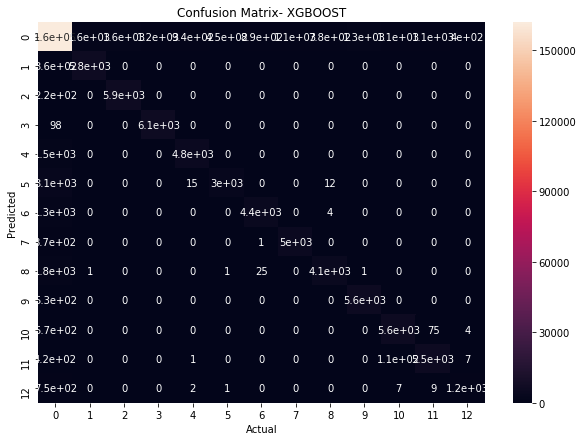

In [ ]:
# Build xgboost model

dtrain = xgb.DMatrix(X_train, label=y_train)

dtest = xgb.DMatrix(X_test, label=y_test)

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

y_pred = bst.predict(dtest)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

labs=set()

# possible labels, 0 is Normal and 1 is LVG
labs.add(0)
labs.add(1)
labs.add(2)
labs.add(3)
labs.add(4)
labs.add(5)
labs.add(6)
labs.add(7)
labs.add(8)
labs.add(9)
labs.add(10)
labs.add(11)
labs.add(12)


array=confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, index = [i for i in list(labs)],
                  columns = [i for i in list(labs)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix- XGBOOST")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.savefig("CM-xgboost.png")

In [ ]:
from sklearn.metrics import classification_report

classes = ["Null class", "Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

print(classification_report(y_test, y_pred, target_names=classes))

                           precision    recall  f1-score   support

               Null class       0.93      0.93      0.93    174298
           Standing still       0.78      0.94      0.85      6121
     Sitting and relaxing       0.79      0.96      0.87      6156
               Lying down       0.83      0.98      0.90      6154
                  Walking       0.83      0.76      0.80      6300
          Climbing stairs       0.87      0.49      0.63      6149
      Waist bends forward       0.83      0.77      0.80      5659
Frontal elevation of arms       0.83      0.85      0.84      5918
Knees bending (crouching)       0.84      0.69      0.76      5948
                  Cycling       0.81      0.91      0.86      6170
                  Jogging       0.83      0.90      0.86      6204
                  Running       0.82      0.91      0.86      6058
        Jump front & back       0.75      0.62      0.68      2014

                 accuracy                           0.90    

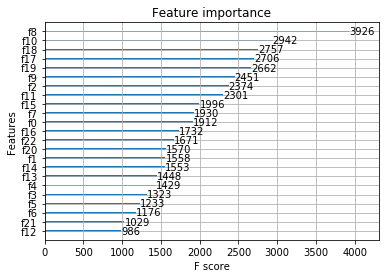

<Figure size 1440x1440 with 0 Axes>

In [ ]:

# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(bst)
pyplot.figure(figsize=(20,20))
pyplot.show()

In [ ]:
# Results
from sklearn import metrics
from numpy import argmax
from sklearn.metrics import accuracy_score

print("XGBoost - Accuracy:{}%".format(100*accuracy_score(y_test, y_pred)))

print("")
print("XGBoost - Precision: {}%".format(100*metrics.precision_score(y_test, y_pred, average="weighted")))
print("XGBoost - Recall: {}%".format(100*metrics.recall_score(y_test, y_pred, average="weighted")))
print("XGBoost - f1_score: {}%".format(100*metrics.f1_score(y_test, y_pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

XGBoost - Accuracy:90.0246351002883%

XGBoost - Precision: 90.15561080511893%
XGBoost - Recall: 90.0246351002883%
XGBoost - f1_score: 89.85236900492076%

Confusion Matrix:
[[161870   1619   1593   1238    936    449    889   1056    784   1308
    1058   1100    398]
 [   362   5759      0      0      0      0      0      0      0      0
       0      0      0]
 [   217      0   5939      0      0      0      0      0      0      0
       0      0      0]
 [    98      0      0   6056      0      0      0      0      0      0
       0      0      0]
 [  1510      0      0      0   4790      0      0      0      0      0
       0      0      0]
 [  3093      0      0      0     15   3029      0      0     12      0
       0      0      0]
 [  1295      0      0      0      0      0   4360      0      4      0
       0      0      0]
 [   874      0      0      0      0      0      1   5043      0      0
       0      0      0]
 [  1825      1      0      0      0      1     25      0   

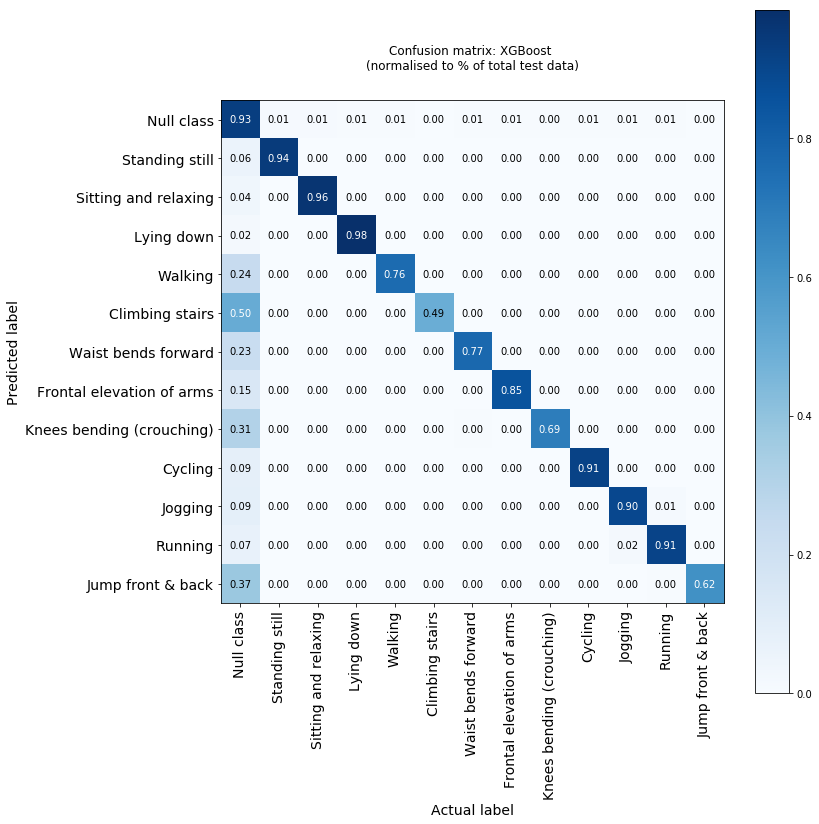

In [ ]:
# The following feature importance code is taken from this link. 
# Referenced in thesis
# https://www.oipapio.com/question-3935333

# Import libraries
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Convert cm to array for multiclass cm
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
multiclass = normalised_confusion_matrix

# labels (classes)
classes = ["Null class", "Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

# plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                               figsize = (12,12))

# plot title, xaxis and yaxis, identify tickmarks, ensure tight layout
plt.title('Confusion matrix: XGBoost \n(normalised to % of total test data)')
plt.xlabel("Actual label", fontsize=14)
plt.ylabel("Predicted label", fontsize=14)
tick_marks = np.arange(13)
plt.xticks(tick_marks, classes, rotation=90, fontsize=14)
plt.yticks(tick_marks, classes, fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:

# Bar chart feature importance

from sklearn.metrics import confusion_matrix as cm
import pandas as pd

# confusion matrix
confusion_matrix=cm(y_test, y_pred)

# Create list containing labels for dataframe below
list1 = ["Null class","Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]
list2 = ["Null class","Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

# convert to pandas dataframe
pd.DataFrame(confusion_matrix, list1,list2)

df = pd.DataFrame(confusion_matrix, list1,list2)
df['Accuracy'] = ['93%','94%','96%','98%','77%','48%','76%','84%','67%','92%','89%','92%','62%']
df = df[1:14]
df

,Null class,Standing still,Sitting and relaxing,Lying down,Walking,Climbing stairs,Waist bends forward,Frontal elevation of arms,Knees bending (crouching),Cycling,Jogging,Running,Jump front & back,Accuracy
Standing still,337,5961,0,0,0,0,0,0,0,0,0,0,0,94%
Sitting and relaxing,234,0,5856,0,0,0,0,0,0,0,0,0,0,96%
Lying down,91,0,0,5999,0,0,0,0,0,0,0,0,0,98%
Walking,1381,0,0,0,4757,0,0,0,0,0,0,0,0,77%
Climbing stairs,3243,0,0,0,19,2918,0,0,14,0,0,0,0,48%
Waist bends forward,1188,0,0,0,0,0,4319,0,3,0,0,0,0,76%
Frontal elevation of arms,870,0,0,0,0,0,0,4973,0,0,0,0,0,84%
Knees bending (crouching),1882,1,0,0,0,4,19,1,4100,1,0,0,0,67%
Cycling,541,0,0,0,0,0,0,0,0,5540,0,0,0,92%
Jogging,555,0,0,0,0,0,0,0,0,1,5437,73,1,89%


In [ ]:
# The following feature importance code is taken from this link. 
# https://www.oipapio.com/question-3935333

# import libraries
from xgboost import plot_importance,XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# import libraries
import numpy as np 
from xgboost import XGBClassifier 

# Set number of estimators
xgb = XGBClassifier(n_estimators=100) 

# feature importance train test split
X_train,X_test,y_train,y_test=model_selection.train_test_split(features,labels,test_size=0.2)

# fit the model, set evaluation set and early stopping rounds
xgb = xgb.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_test,y_test)])

    feature  importance
3       f8         759
4      f18         735
5      f15         682
1      f17         614
10      f2         573
8      f19         540
9      f11         539
0       f0         468
2      f14         460
6      f10         448
7       f7         422
13     f16         370
11      f9         369
15     f22         338
12     f20         270
16      f6         257
18     f13         244
20     f12         196
14      f1         160
17     f21         155
19      f5         149
21      f4          99
22      f3          59


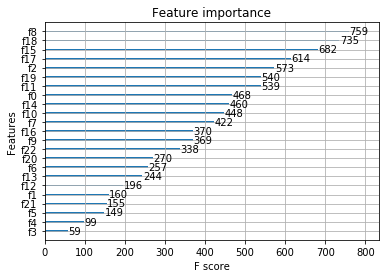

In [ ]:
# import library
import pandas as pd

# fit model
xgb_model=xgb.fit(X_train,y_train)

# convert to pandas dataframe. assign 'feature' and 'importance columns'
xgb_fea_imp=pd.DataFrame(list(xgb_model.get_booster().get_fscore().items()),
                                           
columns=['feature','importance']).sort_values('importance', ascending=False)

# print feature importance for each attribute
print('',xgb_fea_imp)

# plot importance
from xgboost import plot_importance
plot_importance(xgb_model, )